# Figure 2

[Skip code and jump to the figure](#Show-the-figure)

----------------------------------

In [1]:
import warnings

warnings.filterwarnings("ignore")  # noqa

In [2]:
# Scientific and datavis stack
import iris
import matplotlib.pyplot as plt

In [3]:
# My packages
from aeolus.calc import spatial
from aeolus.const import init_const
from aeolus.coord import get_cube_rel_days
from aeolus.core import AtmoSim
from aeolus.io import load_data
from aeolus.model import um
from aeolus.plot import add_custom_legend, subplot_label_generator
from pouch.clim_diag import amplitude_of_wave_crest, longitude_of_wave_crest
from pouch.plot import KW_MAIN_TTL, KW_SBPLT_LABEL, figsave, use_style

In [4]:
# Local modules
import mypaths
from commons import GLM_SUITE_ID, SIM_LABELS, eq_lat

Apply custom matplotlib style sheet.

In [5]:
use_style()

## Load the data for the two key experiments

Define paths to input data and results.

In [6]:
img_prefix = f"{GLM_SUITE_ID}_spinup"
inp_dir = mypaths.sadir / f"{GLM_SUITE_ID}_spinup"
time_prof = "mean_days0_499"
plotdir = mypaths.plotdir / img_prefix

Load processed data.

In [7]:
runs_p = {}
for sim_label, sim_prop in SIM_LABELS.items():
    planet = sim_prop["planet"]
    cl_p = load_data(inp_dir / f"{GLM_SUITE_ID}_{sim_label}_{time_prof}_plev.nc")
    runs_p[sim_label] = AtmoSim(
        cl_p,
        name=sim_label,
        planet=planet,
        const_dir=mypaths.constdir,
        timestep=cl_p[0].attributes["timestep"],
        model=um,
        vert_coord="p",
    )

Define two key pressure levels (also used for other figures).

In [8]:
P_LEV = 300  # hPa
p_lev_constr = iris.Constraint(**{um.pres: P_LEV * 1e2})

Define diagnostics for the emergence of superrotation.

In [9]:
DIAGS = {
    "u_eq_jet_max": {
        "cube": lambda AS: spatial(AS.u.extract(p_lev_constr & eq_lat), "max"),
        "method": "plot",
        "kw_plt": dict(
            color="tab:brown",
        ),
        "title": "Zonal wind at the equator",
        "tex_units": "$m$ $s^{-1}$",
        "lim": [0, 110],
    },
    "wave_crest_lon": {
        "cube": lambda AS: longitude_of_wave_crest(AS.ghgt.extract(p_lev_constr)),
        "method": "plot",
        "kw_plt": dict(
            color="tab:cyan",
        ),
        "title": "Longitude of the wave crest",
        "tex_units": "$\degree$",
        "lim": [-150, 100],
        "ticks": [-150, -90, -45, 0, 45, 90],
    },
    "wave_amplitude": {
        "cube": lambda AS: amplitude_of_wave_crest(AS.ghgt.extract(p_lev_constr))
        / AS.const.gravity,
        "method": "plot",
        "kw_plt": dict(
            color="tab:purple",
        ),
        "title": "Wave amplitude",
        "tex_units": "$m$",
        "lim": [0, 500],
    },
}

In [10]:
vrbls_plot = ["u_eq_jet_max", "wave_amplitude"]

In [11]:
imgname = f"{img_prefix}__{'_'.join(SIM_LABELS)}__{'_'.join(vrbls_plot)}_{P_LEV}hpa"
xlim = [0, 500]
ncols = 2
nrows = 1
window = 10
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 8, nrows * 4))
iletters = subplot_label_generator()

for (sim_label, sim_prop), ax in zip(SIM_LABELS.items(), axs.flat):
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
    ax.set_title(sim_prop["title"], **KW_MAIN_TTL)
    ax2 = ax.twinx()
    ax.set_xlabel("Time [day]")
    the_run = runs_p[f"{sim_label}"]
    for i, (_ax, (vrbl_key, vrbl_dict)) in enumerate(zip((ax, ax2), DIAGS.items())):
        # Calculate diagnostics
        cube = vrbl_dict["cube"](the_run)
        # cube_rm = rolling_mean(cube, um.t, window=window)
        # Plot diagnostics
        if (not _ax.is_first_col()) == i:
            _ax.set_ylabel(
                f'{vrbl_dict["title"]} [{vrbl_dict["tex_units"]}]',
                color=vrbl_dict["kw_plt"]["color"],
                fontsize="medium",
            )
        _ax.set_ylim(vrbl_dict["lim"])
        if "ticks" in vrbl_dict:
            _ax.set_yticks(vrbl_dict["ticks"])
        _ax.set_xlim(xlim)
        if i == 0:
            _ax.hlines(0, *xlim, alpha=0.25, color=vrbl_dict["kw_plt"]["color"])
        _ax.tick_params(axis="y", labelcolor=vrbl_dict["kw_plt"]["color"])
        # _ax.plot(
        #     get_cube_rel_days(cube),
        #     cube.data,
        #     linewidth=0.25,
        #     **vrbl_dict["kw_plt"],
        # )
        _ax.plot(
            get_cube_rel_days(cube),  # get_cube_rel_days(cube_rm) + window,
            cube.data,  # cube_rm.data,
            linewidth=1.5,
            **vrbl_dict["kw_plt"],
        )
    # for period in periods.values():
    # ax.axvspan(*period["days"], color=period["color"], alpha=0.15)
plt.close()

# Show the figure

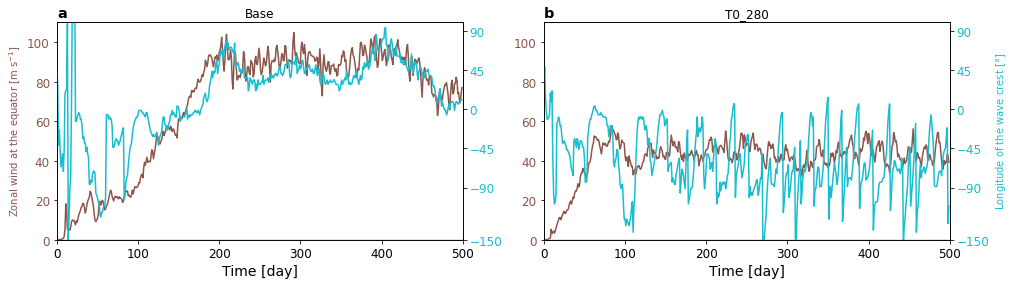

In [12]:
fig

* **Spin-up diagnostics for the (a) _Base_ (b) _T0\_280_ simulations: (brown) maximum zonal wind at the equator at $300\,hPa$ and (cyan) the longitude of stationary Rossby wave crest.**

In [13]:
figsave(fig, plotdir / imgname)

Saved to ../plots/ch111_spinup/ch111_spinup__base_sens-t280k__u_eq_jet_max_wave_amplitude_300hpa.png
